<a href="https://colab.research.google.com/github/aishwaryaprabhat/bike_sharing_demand_prediction/blob/master/model-training/Training_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Clone repo to get the dataset
!git clone https://github.com/aishwaryaprabhat/bike_sharing_demand_prediction.git

Cloning into 'bike_sharing_demand_prediction'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 147 (delta 2), reused 11 (delta 0), pack-reused 126
Receiving objects: 100% (147/147), 11.76 MiB | 10.82 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [ ]:
import pandas as pd
from datetime import datetime
import seaborn as sns
from matplotlib.pyplot import figure

Comments for the head of regional...


In [ ]:
df = pd.read_csv("bike_sharing_demand_prediction/data/bike_sharing_data.csv")

### Creating New Features

In [ ]:
df["date"] = df.datetime.apply(lambda x : x.split()[0])
df["hour"] = df.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype("int")
df["year"] = df.datetime.apply(lambda x : x.split()[0].split("-")[0])
df["weekday"] = df.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())
df["month"] = df.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)

In [ ]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,year,weekday,month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,0,2011,5,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01,1,2011,5,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01,2,2011,5,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01,3,2011,5,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01,4,2011,5,1


### Data Imputation

![](https://github.com/aishwaryaprabhat/bike_sharing_demand_prediction/blob/master/readme_images/5.png?raw=1)

1. Get rid of columns/rows with NA values
2. Impute using mean/median/mode depending on context
3. Build a simple prediction model to impute
4. Replace with 0

In [ ]:
from sklearn.ensemble import RandomForestRegressor

dfWind0 = df[df["windspeed"]==0]
dfWindNot0 = df[df["windspeed"]!=0]
rfModel_wind = RandomForestRegressor()
windColumns = ["season","weather","humidity","month","temp","year","atemp"]
rfModel_wind.fit(dfWindNot0[windColumns], dfWindNot0["windspeed"])

wind0Values = rfModel_wind.predict(X= dfWind0[windColumns])
dfWind0["windspeed"] = wind0Values
df = dfWindNot0.append(dfWind0)
df.reset_index(inplace=True)
df.drop('index',inplace=True,axis=1)

<ipython-input-7-edf8988e9cd5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfWind0["windspeed"] = wind0Values
<ipython-input-7-edf8988e9cd5>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = dfWindNot0.append(dfWind0)


In [ ]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,year,weekday,month
0,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,2011-01-01,5,2011,5,1
1,2011-01-01 10:00:00,1,0,0,1,15.58,19.695,76,16.9979,12,24,36,2011-01-01,10,2011,5,1
2,2011-01-01 11:00:00,1,0,0,1,14.76,16.665,81,19.0012,26,30,56,2011-01-01,11,2011,5,1
3,2011-01-01 12:00:00,1,0,0,1,17.22,21.210,77,19.0012,29,55,84,2011-01-01,12,2011,5,1
4,2011-01-01 13:00:00,1,0,0,2,18.86,22.725,72,19.9995,47,47,94,2011-01-01,13,2011,5,1


### Dealing with non-numerical Data

In [ ]:
categoricalFeatureNames = ["season","holiday","workingday","weather","weekday","month","year","hour"]
numericalFeatureNames = ["temp","humidity","windspeed","atemp"]
dropFeatures = ['casual',"count","datetime","date","registered", "atemp"]
for var in categoricalFeatureNames:
    df[var] = df[var].astype("category")

## Model Training

At this point we have a good idea of what our data and features look like. Next thing we need to know is how well does our model need to perform.

![](https://github.com/aishwaryaprabhat/bike_sharing_demand_prediction/blob/master/readme_images/6.png?raw=1)

### Splitting into training and test set

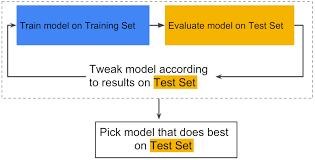

In [ ]:
df = df[pd.notnull(df['count'])].sort_values(by=["datetime"])
df_train = df[:-2000]
df_test = df[-2000:]

x_train  = df_train.drop(dropFeatures,axis=1)
y_train = df_train["count"]

x_test = df_test.drop(dropFeatures,axis=1)
y_test = df_test['count']

In [ ]:
print(x_train.shape)
x_train.head()

(8886, 11)


,season,holiday,workingday,weather,temp,humidity,windspeed,hour,year,weekday,month
9573,1,0,0,1,9.84,81,11.637310,0,2011,5,1
9574,1,0,0,1,9.02,80,11.462438,1,2011,5,1
9575,1,0,0,1,9.02,80,11.462438,2,2011,5,1
9576,1,0,0,1,9.84,75,7.173031,3,2011,5,1
9577,1,0,0,1,9.84,75,7.173031,4,2011,5,1


In [ ]:
print(x_test.shape)
x_test.head()

(2000, 11)


,season,holiday,workingday,weather,temp,humidity,windspeed,hour,year,weekday,month
7841,3,0,0,1,31.16,40,8.998100,15,2012,6,8
7842,3,0,0,1,31.16,40,7.001500,16,2012,6,8
10618,3,0,0,1,32.80,33,10.959811,17,2012,6,8
7843,3,0,0,1,31.98,35,7.001500,18,2012,6,8
7844,3,0,0,1,30.34,40,8.998100,19,2012,6,8


### Training Models

In [ ]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
import numpy as np
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

##### Choosing a metric

![](https://i.stack.imgur.com/83BUy.png)

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):

#     y_true, y_pred = check_arrays(y_true, y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

#### (Multivariate) Linear Regression Model

![](https://www.jmp.com/en_hk/statistics-knowledge-portal/what-is-multiple-regression/fitting-multiple-regression-model/_jcr_content/par/styledcontainer_2069/par/lightbox_4130/lightboxImage.img.png/1548704005203.png)

![](https://usercontent1.hubstatic.com/6177878_f520.jpg)

In [ ]:
# Initialize logistic regression model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

linreg_model = make_pipeline(StandardScaler(), LinearRegression())

# Train the model
linreg_model.fit(X = x_train, y = y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [ ]:
training_predictions = linreg_model.predict(x_train)

#Training Error
mean_absolute_percentage_error(y_train, training_predictions)

340.56787742520703

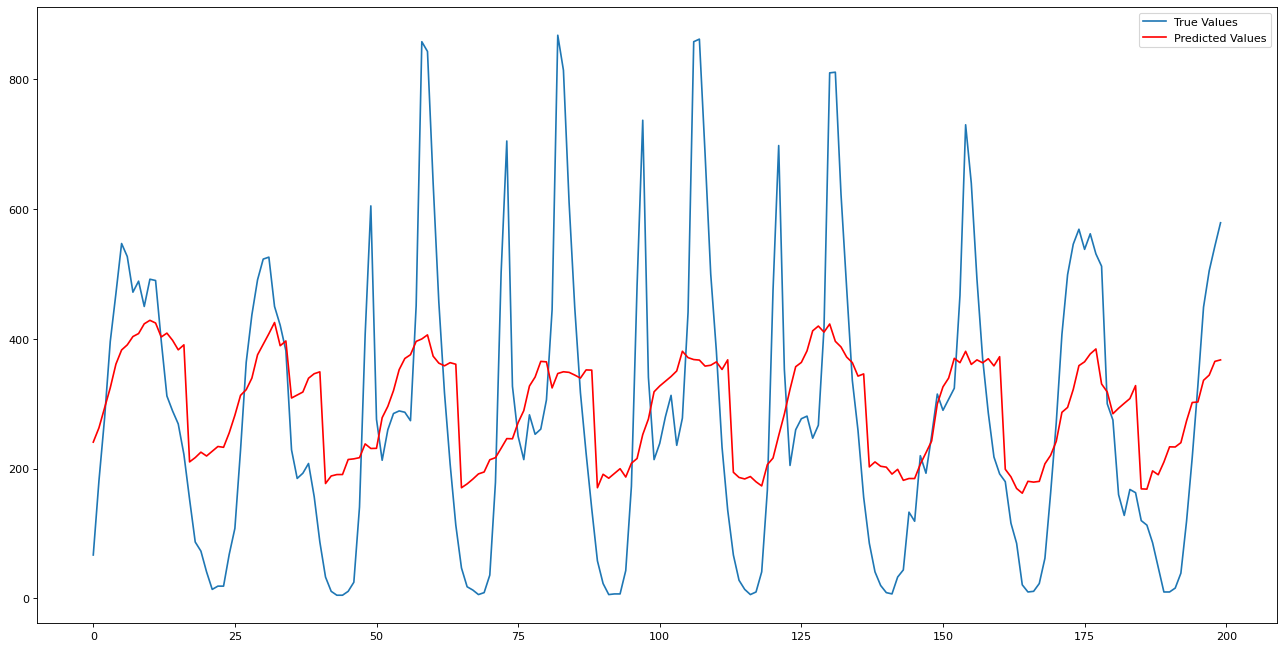

In [ ]:
from matplotlib import pyplot as plt
figure(num=None, figsize=(20,10), dpi=80, facecolor='w', edgecolor='k')

view_number=200
index = [x for x in range(len(y_test))]
plt.plot(y_train.values[-view_number:], label='True Values')
plt.plot(training_predictions[-view_number:], c='r', label='Predicted Values')
plt.legend()

In [ ]:
test_predictions = linreg_model.predict(x_test)
mean_absolute_percentage_error(y_test, test_predictions)

347.7231418416945

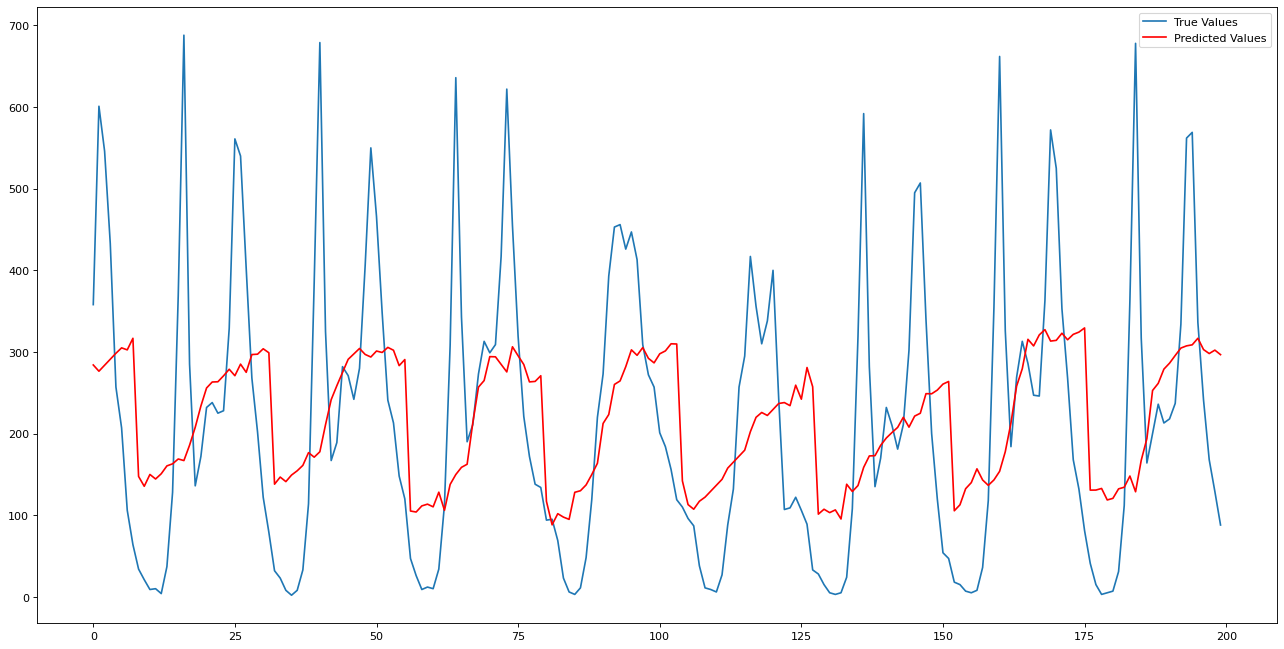

In [ ]:
from matplotlib import pyplot as plt
figure(num=None, figsize=(20,10), dpi=80, facecolor='w', edgecolor='k')

view_number=200
index = [x for x in range(len(y_test))]
plt.plot(y_test.values[-view_number:], label='True Values')
plt.plot(test_predictions[-view_number:], c='r', label='Predicted Values')
plt.legend()

#### Decision Tree Model

![](https://media.geeksforgeeks.org/wp-content/cdn-uploads/Decision_Tree-2.png)

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dt_model = DecisionTreeRegressor()
dt_model.fit(x_train, y_train)

DecisionTreeRegressor()

In [ ]:
training_predictions = dt_model.predict(X= x_train)
mean_absolute_percentage_error(y_train, training_predictions)

0.03961577797093973

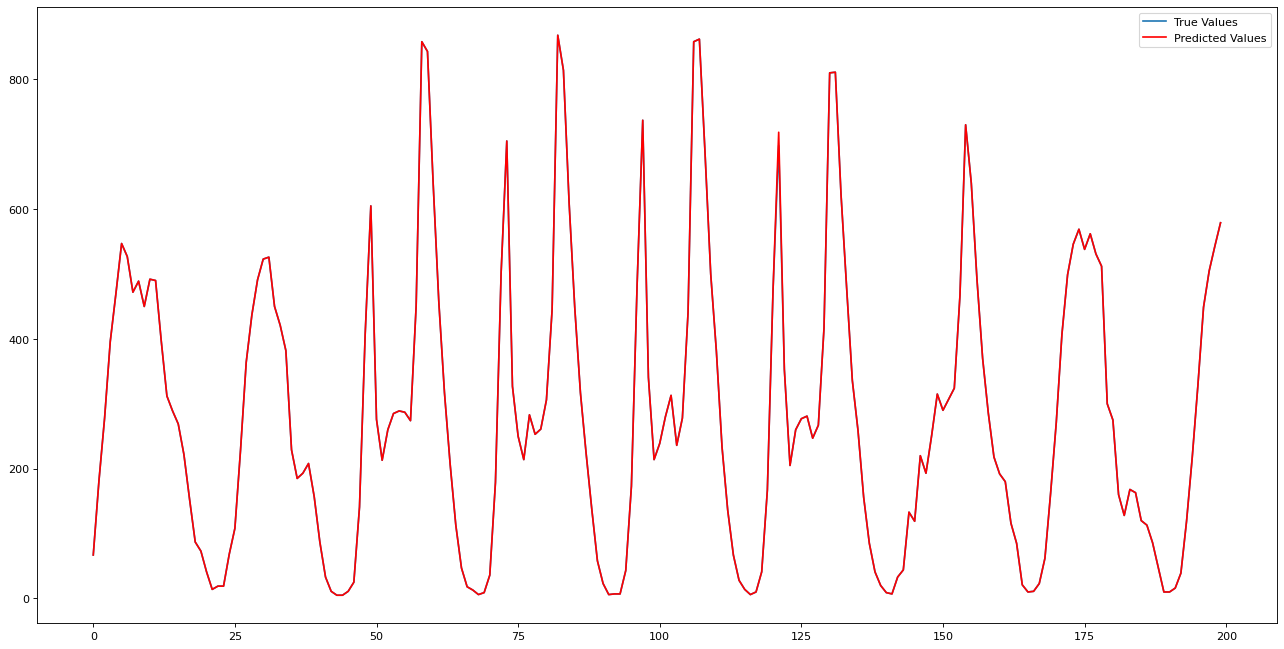

In [ ]:
from matplotlib import pyplot as plt
figure(num=None, figsize=(20,10), dpi=80, facecolor='w', edgecolor='k')

view_number=200
index = [x for x in range(len(y_test))]
plt.plot(y_train.values[-view_number:], label='True Values')
plt.plot(training_predictions[-view_number:], c='r', label='Predicted Values')
plt.legend()

In [ ]:
test_predictions = dt_model.predict(X= x_test)
mean_absolute_percentage_error(y_test, test_predictions)

36.61217659095037

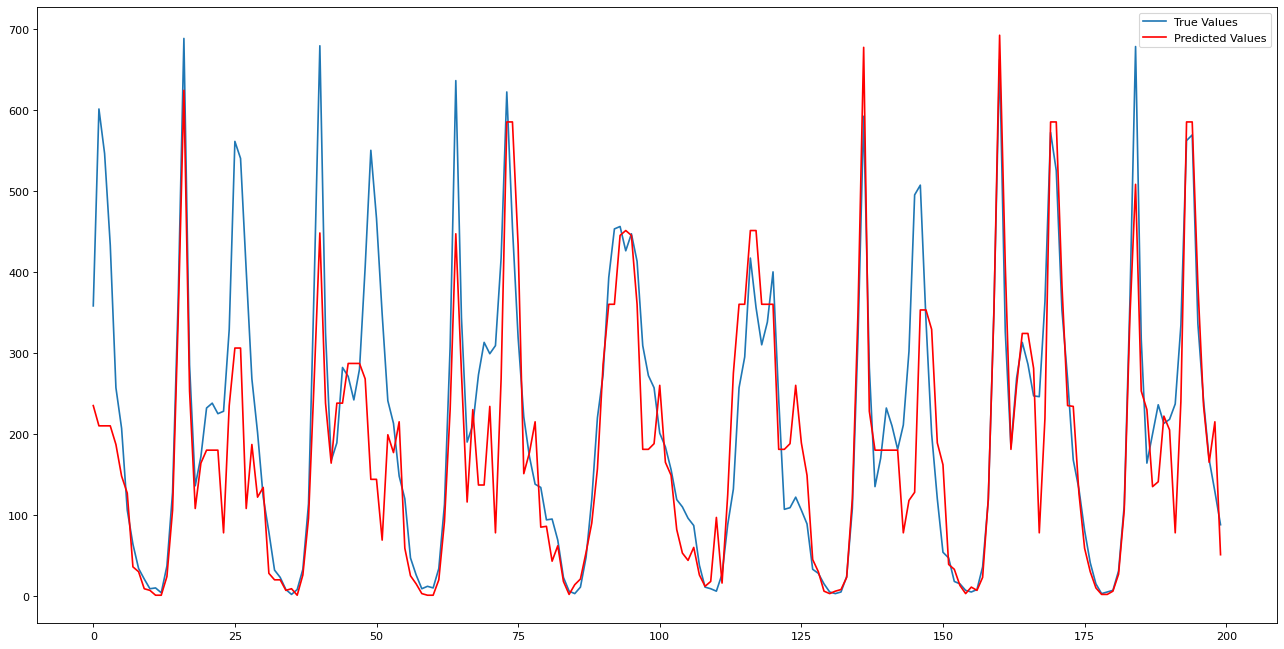

In [ ]:
from matplotlib import pyplot as plt
figure(num=None, figsize=(20,10), dpi=80, facecolor='w', edgecolor='k')

view_number=200
index = [x for x in range(len(y_test))]
plt.plot(y_test.values[-view_number:], label='True Values')
plt.plot(test_predictions[-view_number:], c='r', label='Predicted Values')
plt.legend()

#### Reducing Overfitting by Reducing Model Complexity

In [ ]:
dt_model = DecisionTreeRegressor(max_depth=10)
dt_model.fit(x_train, y_train)

training_predictions = dt_model.predict(X= x_train)
mean_absolute_percentage_error(y_train, training_predictions)

27.288407444257956

[Text(0.5, 0.8333333333333334, 'hour <= 6.5\nsquared_error = 28369.714\nsamples = 8886\nvalue = 176.465'),
 Text(0.25, 0.5, 'hour <= 5.5\nsquared_error = 1324.317\nsamples = 2559\nvalue = 29.952'),
 Text(0.125, 0.16666666666666666, 'squared_error = 808.192\nsamples = 2187\nvalue = 23.222'),
 Text(0.375, 0.16666666666666666, 'squared_error = 2527.051\nsamples = 372\nvalue = 69.516'),
 Text(0.75, 0.5, 'temp <= 19.27\nsquared_error = 27114.769\nsamples = 6327\nvalue = 235.723'),
 Text(0.625, 0.16666666666666666, 'squared_error = 13727.596\nsamples = 2714\nvalue = 155.154'),
 Text(0.875, 0.16666666666666666, 'squared_error = 28631.756\nsamples = 3613\nvalue = 296.245')]

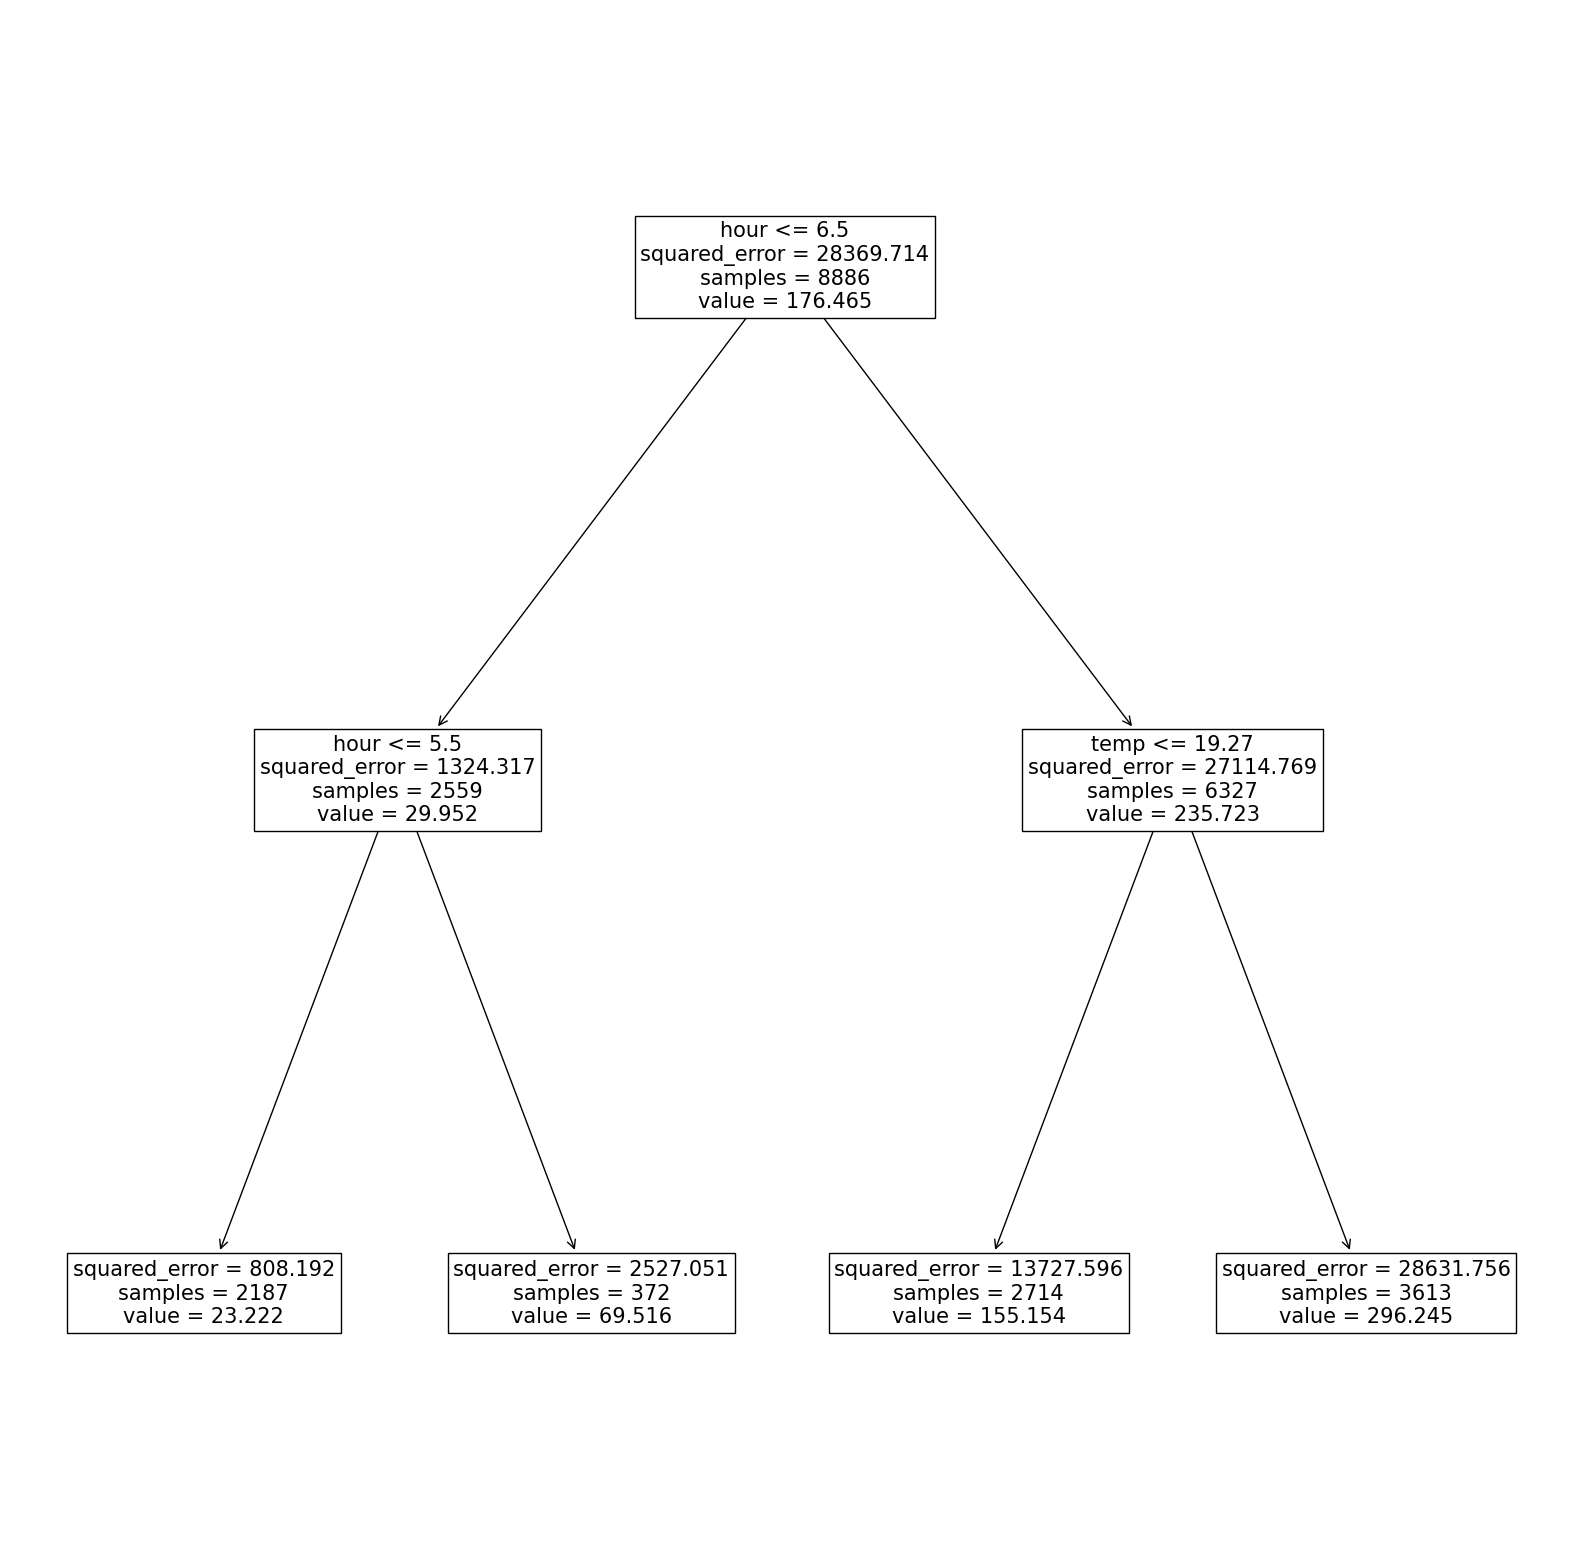

In [ ]:
# # No need to import StringIO from sklearn.externals.six; use io.StringIO instead
from io import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus


# #smaller model for visualization purposes
# dt_model_small = DecisionTreeRegressor(max_depth=2)
# dt_model_small.fit(x_train, y_train)

# # Assuming dt_model is your trained decision tree model
# dot_data = StringIO()
# export_graphviz(dt_model_small, out_file=dot_data,
#                 filled=True, rounded=True,
#                 special_characters=True)

# # Generate the graph from dot_data
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# # Display the image
# Image(graph.create_png())

from sklearn import tree
plt.figure(figsize=(20,20))  # set plot size (denoted in inches)

dt_model_small = DecisionTreeRegressor(max_depth=2)
dt_model_small.fit(x_train, y_train)
text_representation = tree.export_graphviz(dt_model_small)
tree.plot_tree(dt_model, feature_names=x_train.columns, fontsize=15)


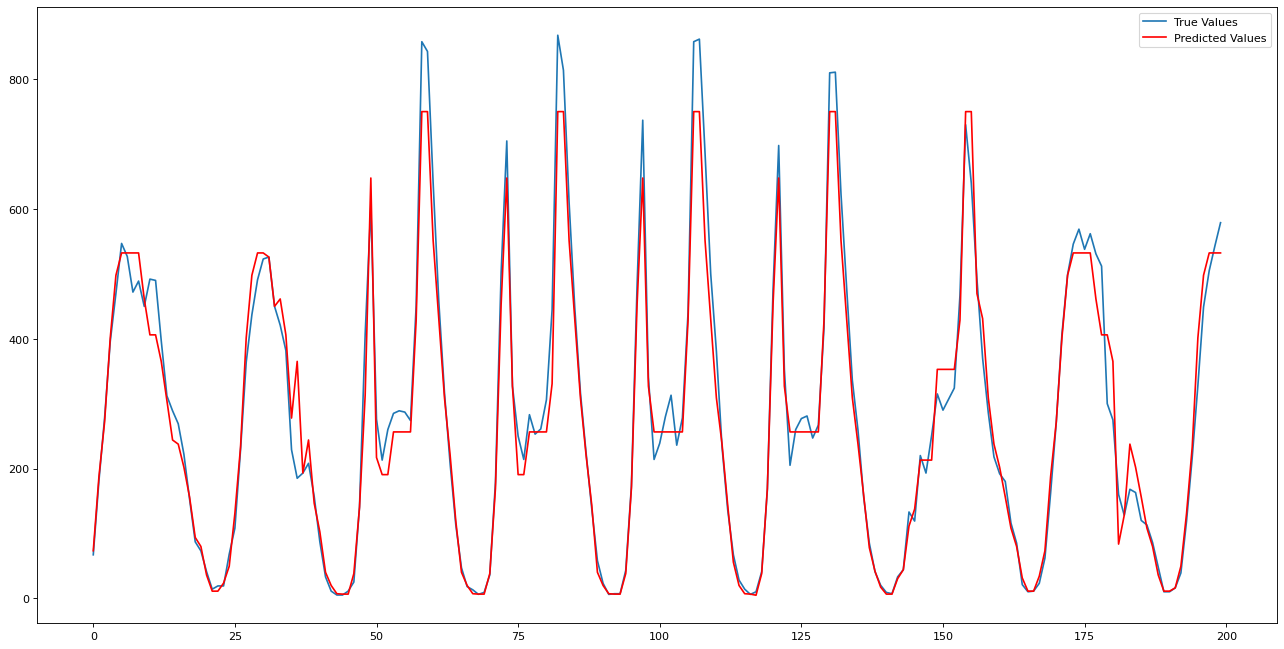

In [ ]:
from matplotlib import pyplot as plt
figure(num=None, figsize=(20,10), dpi=80, facecolor='w', edgecolor='k')

view_number=200
index = [x for x in range(len(y_test))]
plt.plot(y_train.values[-view_number:], label='True Values')
plt.plot(training_predictions[-view_number:], c='r', label='Predicted Values')
plt.legend()

In [ ]:
test_predictions = dt_model.predict(X= x_test)
mean_absolute_percentage_error(y_test, test_predictions)

33.880076142825544

#### RandomForest Model

![](https://www.researchgate.net/profile/Evaldas_Vaiciukynas/publication/301638643/figure/fig1/AS:355471899807744@1461762513154/Architecture-of-the-random-forest-model.png)

In [ ]:
rf_model = RandomForestRegressor(n_estimators=10)
rf_model.fit(x_train, y_train)

RandomForestRegressor(n_estimators=10)

In [ ]:
training_predictions = rf_model.predict(X= x_train)
mean_absolute_percentage_error(y_train, training_predictions)

11.701964609118086

In [ ]:
test_predictions = rf_model.predict(x_test)
mean_absolute_percentage_error(y_test, test_predictions)

27.897794322388364

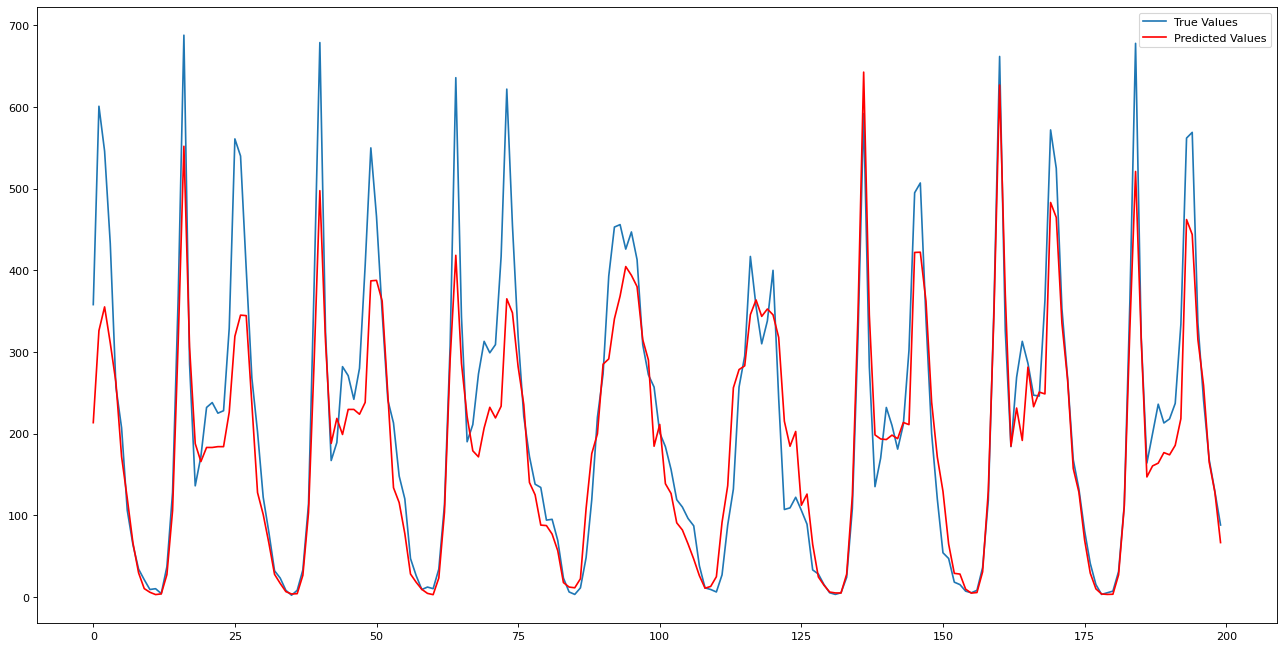

In [ ]:
from matplotlib import pyplot as plt
figure(num=None, figsize=(20,10), dpi=80, facecolor='w', edgecolor='k')

view_number=200
index = [x for x in range(len(y_test))]
plt.plot(y_test.values[-view_number:], label='True Values')
plt.plot(test_predictions[-view_number:], c='r', label='Predicted Values')
plt.legend()

![](https://github.com/aishwaryaprabhat/bike_sharing_demand_prediction/blob/master/readme_images/7.png?raw=1)

### Building an API

![](http://blog.restcase.com/content/images/2016/11/api-collaboration.png)

An application programming interface is an interface or communication protocol between a client and a server intended to simplify the building of client-side software.

![](https://github.com/aishwaryaprabhat/bike_sharing_demand_prediction/blob/master/readme_images/10.png?raw=1)

### Exporting Model

In [ ]:
import pickle
import os

pickle.dump(rf_model,open("bike_sharing_demand_prediction/models/rf_model.pkl",'wb'))

In [ ]:
loaded_model = pickle.load(open("bike_sharing_demand_prediction/models/rf_model.pkl",'rb'))
result = loaded_model.predict(x_train[-1:])
result

array([554.3])

In [ ]:
x_train[-1:]

,season,holiday,workingday,weather,temp,humidity,windspeed,hour,year,weekday,month
7840,3,0,0,1,31.16,40,12.998,14,2012,6,8


In [ ]:
y_train[-1:]

7840    579
Name: count, dtype: int64

![](https://github.com/aishwaryaprabhat/bike_sharing_demand_prediction/blob/master/readme_images/9.png?raw=1)

### Containerization

![](https://github.com/aishwaryaprabhat/bike_sharing_demand_prediction/blob/master/readme_images/8.png?raw=1)

![](https://github.com/aishwaryaprabhat/bike_sharing_demand_prediction/blob/master/readme_images/11.png?raw=1)

![](https://github.com/aishwaryaprabhat/bike_sharing_demand_prediction/blob/master/readme_images/12.png?raw=1)

### Container Orchestration

![](https://github.com/aishwaryaprabhat/bike_sharing_demand_prediction/blob/master/readme_images/13.png?raw=1)

![](https://github.com/aishwaryaprabhat/bike_sharing_demand_prediction/blob/master/readme_images/14.png?raw=1)

## Where can I learn about Machine Learning?

- https://pythonprogramming.net/
- https://www.youtube.com/playlist?list=PLOg0ngHtcqbPTlZzRHA2ocQZqB1D_qZ5V
- https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1491962291
- https://www.udemy.com/course/machinelearning/

(remember to cover misc questions)

![](https://ml4a.github.io/images/figures/mnist_1layer.png)

1. How and where can I use machine learning in supply chain plannning and management?
2. how much should we learn or what extent that we master in machine learning can make us get a job in data science
3. machine learning‘s specific and now-in-use application in supply chain
4. The applications of Machine Learning in Supply Chain field as well as the new trending (or outlook).
5. What are the most frequently used ML algorithm in industry/work?
6. What kind of skills do I need
7. What skills are considered for a data science job? How much would your degree matter?
8. What the pre requirements before learning machine learning? (eg. Are there any necessary skills to master before learning Machine Learning?)
9. Which industries can use Machine Learning?